## 0. Import Modules

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [7]:
data = pd.read_excel('sample_data_populationdensity_schoolenrollment.xls')

# remove outlier
data = data[1:]
data.head()

,Country Name,Country Code,"School enrollment, tertiary (% gross)",Population density (people per sq. km of land area)
1,Bahrain,BHR,55.628510,2095.994891
2,Maldives,MDV,34.121941,1769.856667
3,Malta,MLT,64.872910,1575.193750
4,Bangladesh,BGD,24.016890,1252.563363
5,West Bank and Gaza,PSE,43.235481,778.290033


## 1. Test for Difference between Two Population Means

### Divide your data into two groups using median

In [8]:
p_col = 'Population density (people per sq. km of land area)'
s_col = 'School enrollment, tertiary (% gross)'

cutting_point = data[p_col].median()
cond = data[p_col] > cutting_point

group1, group2 = data[cond], data[~cond]

In [16]:
mean1 = group1[s_col].mean()
mean2 = group2[s_col].mean()

var1 = group1[s_col].var(ddof=1) # the divisor used in the calculation is N - ddof
var2 = group2[s_col].var(ddof=1)

n1 = len(group1[s_col])
n2 = len(group2[s_col])

In [17]:
group1_data = {}
group1_data['Mean'] = mean1
group1_data['Variance'] = var1
group1_data['Observations'] = n1

group2_data = {}
group2_data['Mean'] = mean2
group2_data['Variance'] = var2
group2_data['Observations'] = n2

group_table = pd.DataFrame({'Group 1' : group1_data, 'Group 2':group2_data},)
group_table

,Group 1,Group 2
Mean,46.001667,51.384338
Variance,684.344257,1032.127494
Observations,59.000000,60.000000


### Compute the value of the test statistic.


### $ t = \frac{\bar{x_1} - \bar{x_2}}{\sqrt{\frac{(s_1)^2}{n_1} + \frac{(s_2)^2}{n_2}}}$

In [18]:
t_term1 = mean1 - mean2
t_term2 = np.sqrt((var1 / n1) + (var2 / n2))
t = t_term1 / t_term2

print(f'Test Statistic: {t}')

Test Statistic: -1.0029810681786937


### Compute the degree of freedom.

### $df = \frac{[({s_1}^2/n_1) + ({s_2}^2/n_2)]^2}{\frac{{({s_1}^2/n_1)}^2}{n_1-1} + \frac{{({s_2}^2/n_2)}^2}{n_2-1}}$

In [22]:
df_term1 = np.power((var1/n1 + var2/n2), 2)
df_term2 = (np.power(var1/n1, 2) / (n1-1)) + (np.power(var2/n2, 2) / (n2-1))

df = df_term1 / df_term2
print(f'Degree of Freedom: {df}')

Degree of Freedom: 113.08750498357395


### Find the p-value

In [37]:
p_value = stats.t.cdf(t, df=df)
print(f'p_value: {p_value}')

p_value: 0.15900564057364724


In [38]:
ttest_table = pd.DataFrame(
{'t-Test':
    {
        'df': df, 
        't Stat': t, 
        'P(T<=t) one tail': p_value,
        't Critical one-tail': stats.t.ppf(q=.05,df=df),
        't Critical two-tail': stats.t.ppf(q=.025,df=df),
        'P(T<=t) two tail': p_value*2,
    }
})
ttest_table

,t-Test
P(T<=t) one tail,0.159006
P(T<=t) two tail,0.318011
df,113.087505
t Critical one-tail,-1.658440
t Critical two-tail,-1.981164
t Stat,-1.002981


## 2. Test for the Equality of k Population Means

### Divide your data into four groups using quartile

In [39]:
data['Quartile']= pd.qcut(data[p_col], [0, .25, .5, .75, 1.]) # k = 4
(_, group1), (_, group2), (_, group3), (_, group4) = data.groupby('Quartile')

### SUMMARY

In [57]:
group_summary = data[[s_col, 'Quartile']].groupby('Quartile')
group_summary.agg(['count', 'sum', 'mean', 'var'])

School enrollment, tertiary (% gross)  \
                                                             count   
Quartile                                                             
(2.0700000000000003, 44.996]                                    30   
(44.996, 92.782]                                                30   
(92.782, 207.104]                                               29   
(207.104, 2095.995]                                             30   

                                                                  
                                      sum       mean         var  
Quartile                                                          
(2.0700000000000003, 44.996]  1789.464810  59.648827  984.998945  
(44.996, 92.782]              1293.595482  43.119849  973.532629  
(92.782, 207.104]             1522.886629  52.513332  743.699510  
(207.104, 2095.995]           1191.211705  39.707057  567.243636

### Perform one-way ANOVA

In [9]:
F, p = stats.f_oneway(
    group1[s_col], 
    group2[s_col], 
    group3[s_col], 
    group4[s_col]
)

# The same code as above code.
# group_list = [group[s_col] for _ , group in list(data.groupby('Quartile'))]
# F, p = stats.f_oneway(*group_list)

print(f'F-Ratio: {F}, p-value: {p}')

F-Ratio: 3.0066130390511288, p-value: 0.03324034926172625


### You can also get ANOVA table by using statsmodels package.

In [10]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

temp = data[[s_col, 'Quartile']].copy()
temp.columns = ['value', 'group']

model = ols('value ~ C(group)', temp).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),3.0,7378.312115,2459.437372,3.006613,0.03324
Residual,115.0,94071.067361,818.009281,NaN,NaN


## 3. Linear Regression

### Slope for the Estimated Regression Equation

### $ b_1 = \frac{\sum{(x_i-\bar{x})(y_i -\bar{y})}}{\sum{(x_i - \bar{x})^2}}$

In [11]:
mean_x = data[p_col].mean()
mean_y = data[s_col].mean()

In [12]:
b1_term1 = np.sum((data[p_col] - mean_x)*(data[s_col] - mean_y))
b1_term2 = np.sum(np.power(data[p_col] - mean_x, 2))

b1 = b1_term1 / b1_term2
b1

-0.008476437681019407

### y-Intercept for the Estimated Regression Equation

### $b_0 = \bar{y} - b_1\bar{x}$

In [13]:
b0 = mean_y - b1*mean_x
b0

50.31276597866713

### Estimated Regression Equation

### $\hat{y} = b_0 + b_1x$

In [14]:
data['y_hat'] = b0 + b1*data[p_col]

### Plot regression line

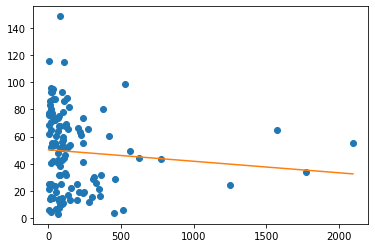

In [15]:
plt.plot(data[p_col],data[s_col], 'o')
plt.plot(data[p_col], data['y_hat'])
plt.show()

### Compare our results with results from sckit-learn

In [16]:
# Please insatll scikit-learn if the package was not installed.
!pip install scikit-learn

In [61]:
from sklearn.linear_model import LinearRegression

X = data[p_col].values.reshape(-1,1)
y = data[s_col].values.reshape(-1,1)

reg = LinearRegression().fit(X, y)
reg.intercept_, reg.coef_

(array([50.31276598]), array([[-0.00847644]]))

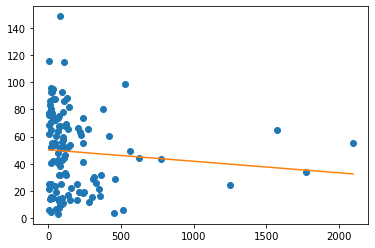

In [62]:
plt.plot(X,y, 'o')
plt.plot(X, reg.predict(X))
plt.show()

### Error Term Plotting

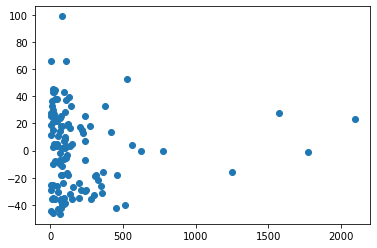

In [79]:
plt.plot(X, y-reg.predict(X), 'o')
plt.show()

### Recommend statsmodels if you want to get concrete results.

In [67]:
from statsmodels.api import OLS
from statsmodels.api import add_constant

X2 = add_constant(X)
est = OLS(y, X2)
est = est.fit()

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9986
Date:                Mon, 05 Dec 2022   Prob (F-statistic):              0.320
Time:                        19:20:43   Log-Likelihood:                -569.87
No. Observations:                 119   AIC:                             1144.
Df Residuals:                     117   BIC:                             1149.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.3128      3.127     16.089      0.000      44.120      56.506
x1            -0.0085      0.008     -0.999      0.320      -0.025       0.008
==============================================================================
Omnibus:                        3.256   Durbin-Watson:                   2.128
Prob(Omnibus):                  0.196   Jarque-Bera (JB):                3.244
Skew:                           0.394   Prob(JB):                        0.198
Kurtosis:                       2.818   Cond. No.                         429.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""